In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Na stronie https://github.com/vlosing/driftDatasets znajduje się kolekcja zbiorów danych (rzeczywistych i syntetycznych) związanych z dryfem. Należy pobrać z niej zbiór hyperplane (lub dowolny inny).

In [2]:
DATA_PATH = 'https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.data'
LABEL_PATH = 'https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.labels'

In [3]:
x_data = pd.read_csv(DATA_PATH, sep=' ', header=None)
y_data = pd.read_csv(LABEL_PATH, header=None)

In [4]:
x_data.shape

(200000, 10)

### 2. Szukamy zmian pomiędzy pierwszymi 10% zbioru danych i ostatnimi 10% zbioru danych. W tym celu należy zbudować model (np. regresji logistycznej) na obu częściach danych. Wyznaczyć rozkłady zmiennych i policzyć odległosci pomiędzy odpowiedziami modelu na obu zbiorach danych.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [6]:
CUTOFF = x_data.shape[0] // 10
x_data_head = x_data.head(CUTOFF)
y_data_head = y_data.head(CUTOFF).values.reshape(-1)
x_train_head, x_test_head, y_train_head, y_test_head = train_test_split(x_data_head, y_data_head, test_size = 0.25)


x_data_tail = x_data.tail(CUTOFF)
y_data_tail = y_data.tail(CUTOFF).values.reshape(-1)
x_train_tail, x_test_tail, y_train_tail, y_test_tail = train_test_split(x_data_tail, y_data_tail, test_size = 0.25)

In [7]:
lr_head = LogisticRegression()
lr_head.fit(x_train_head, y_train_head);
lr_tail = LogisticRegression()
lr_tail.fit(x_train_tail, y_train_tail);

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 3. Dla dwóch wybranych podzbiorów policz:

#### (A) Intersection distance dla każdej zmiennej (V1-V10) ze zbioru danych.

In [8]:
def intersection_distance(feat_head, feat_tail, bins=50):
    head_hist = np.histogram(feat_head, density=True, bins=bins)[0]
    tail_hist = np.histogram(feat_tail, density=True, bins=bins)[0]
    return 1 - np.minimum(head_hist, tail_hist) @ np.diff(bins)


In [9]:
def plot_drift(feat_head, feat_tail, feat_n=0, ax=None, bins=50):
    quantile_bins = pd.concat([feat_head, feat_tail]).quantile(np.linspace(0, 1, bins + 1))
    inter_dist = intersection_distance(feat_head, feat_tail, bins=quantile_bins)
    
    sns.set()
    sns.set_style("whitegrid")
    sns.distplot(feat_head, bins=quantile_bins, kde=False, norm_hist=True, hist_kws={"alpha": 0.5}, label="Head", ax=ax)
    sns.distplot(feat_tail, bins=quantile_bins, kde=False, norm_hist=True, hist_kws={"alpha": 0.5}, label="Tail", ax=ax)
    if ax:
        ax.set_title("{}: intersect distance = {:.4f}".format(feat_n, inter_dist))
        ax.legend(loc='right')
    else:
        plt.title("{}: intersect distance = {:.4f}".format(feat_n, inter_dist))
        plt.legend(loc='right')
        
    

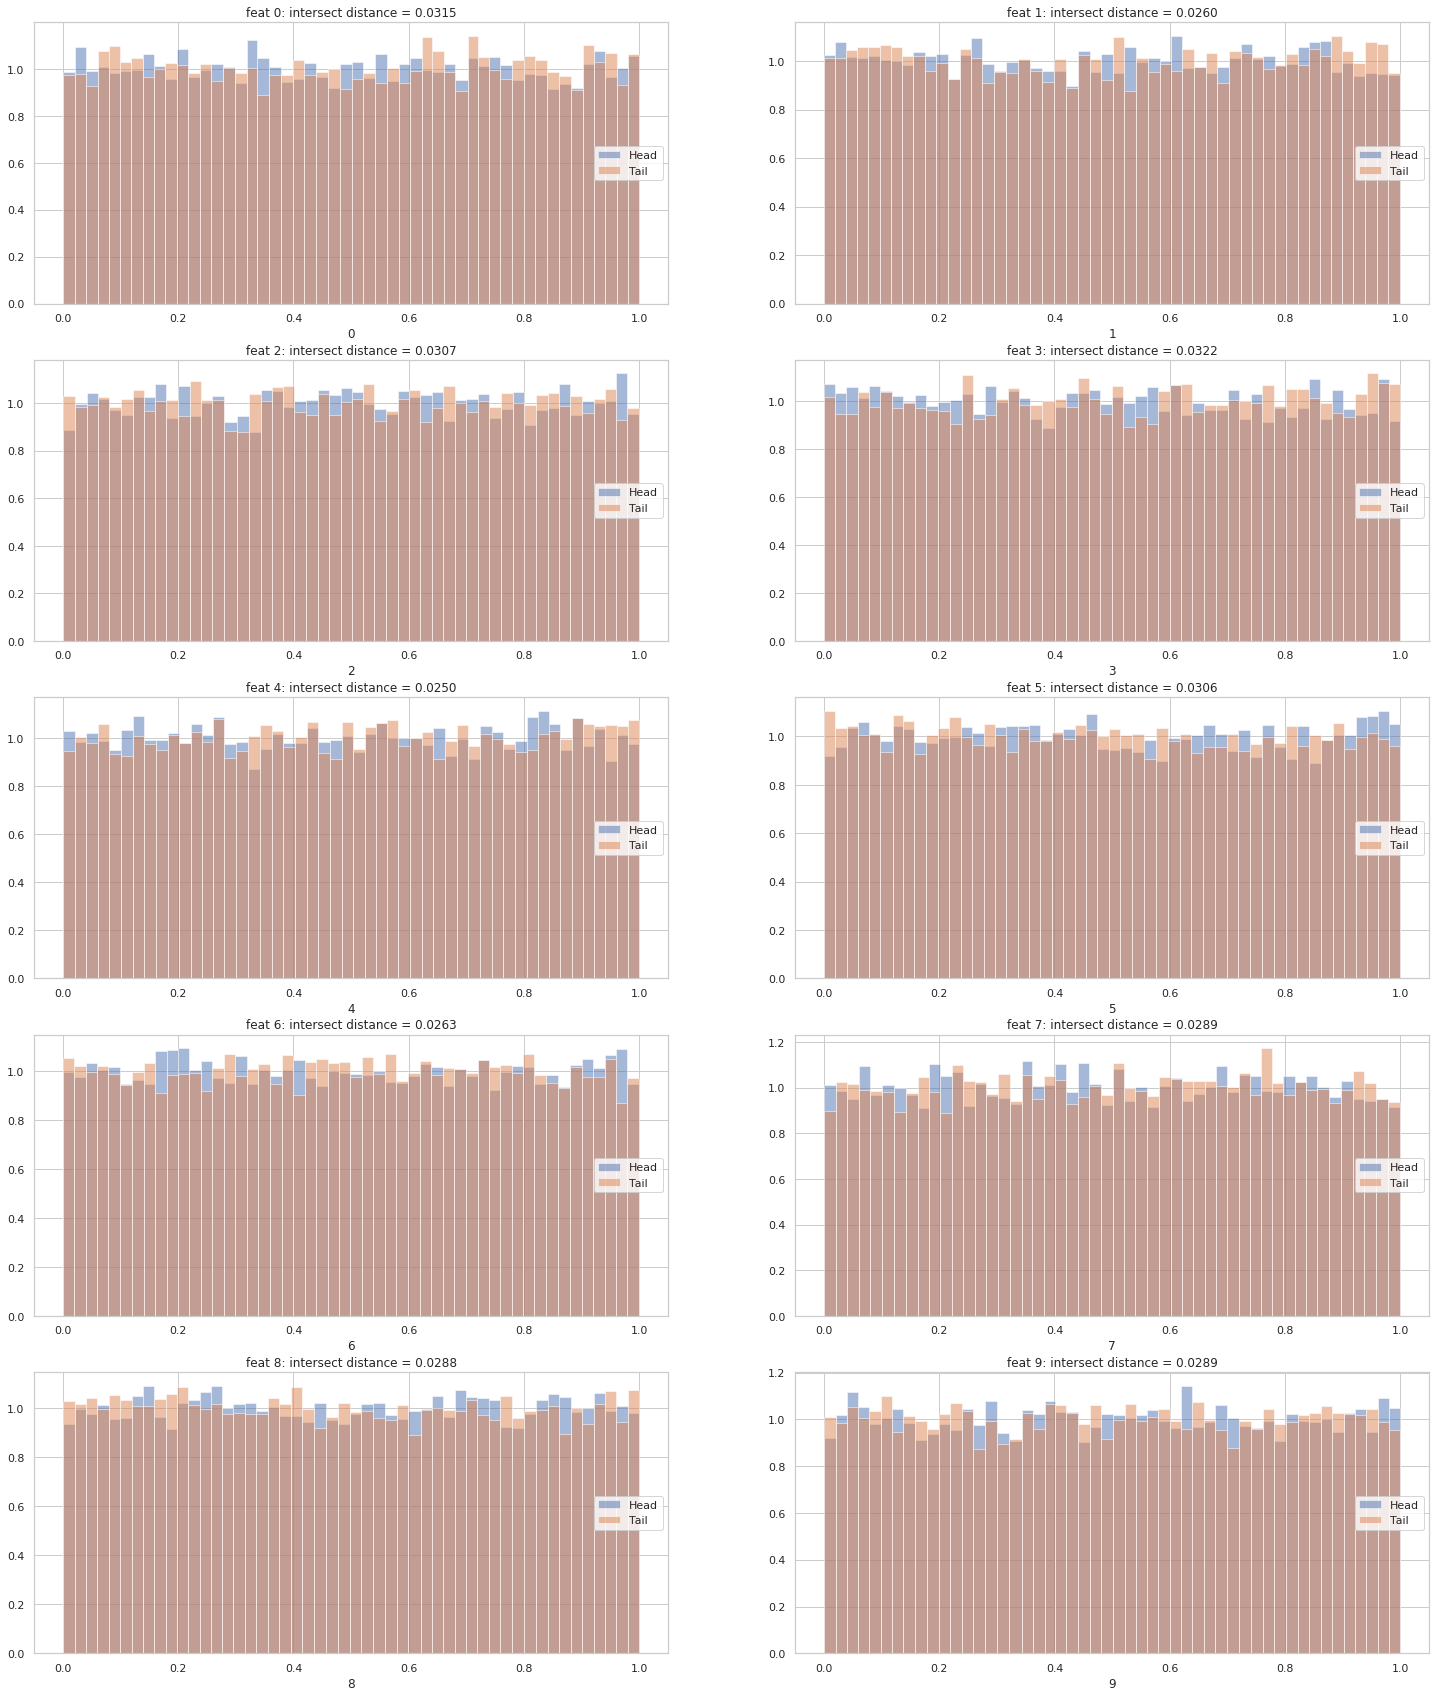

In [12]:
feat_no = x_data.columns.shape[0]
fig, ax = plt.subplots(ncols=2, nrows=(feat_no+1)//2, figsize=(25, 30))
for i, feature in enumerate(x_data.columns):
    plot_drift(x_data_head[feature], x_data_tail[feature], feat_n="feat {}".format(feature), ax=ax[i//2][i%2])

Nie widać zmian przy badaniu dryftu większych niż $0.033$, czego można się spodziewać przy losowaniu punktów z rozkładu jednostajego.

#### (B) Intersection distance dla reszt z obu modeli.

##### Model wytrenowany na początkowym ogonie danych

In [13]:
res1 = y_test_head - lr_head.predict_proba(x_test_head)[:, 1]
res2 = y_test_tail - lr_head.predict_proba(x_test_tail)[:, 1]

res1 = pd.Series(res1)
res2 = pd.Series(res2)

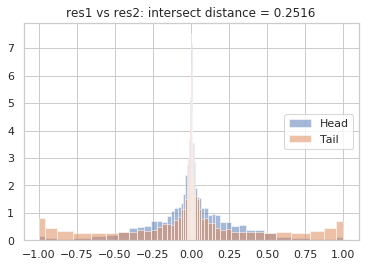

In [14]:
plot_drift(res1, res2, feat_n="res1 vs res2")

##### Model wytrenowany na końcowym ogonie danych

In [15]:
res1 = y_test_head - lr_tail.predict_proba(x_test_head)[:, 1]
res2 = y_test_tail - lr_tail.predict_proba(x_test_tail)[:, 1]

res1 = pd.Series(res1)
res2 = pd.Series(res2)

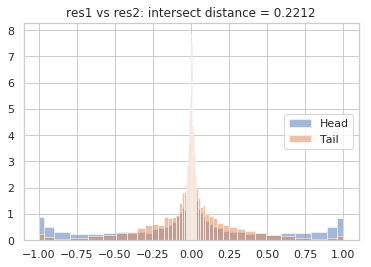

In [16]:
plot_drift(res1, res2, feat_n="res1 vs res2", ax=None)

W obu przypadkach odległość jest większa niż 20%, oraz widać różnicę częstości na ogonach rozkładu

#### (C) Pole pomiędzy krzywymi PDP dla obu modeli.

In [22]:
def calculate_pdp_values(model, df, feature, no_points, points):
    x = np.linspace(points[0], points[1], num=no_points, endpoint=True)
    y_cum = []
    df_columns = df.columns
    for row_index in range(df.shape[0]):
        sample = pd.DataFrame(columns=df_columns)
        sample.loc[0] = df.iloc[row_index, :]
        samples = sample.append([sample.iloc[0, :]]*(no_points-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = model.predict_proba(samples)[:, 1]
        y_cum.append(y)
    y_cum = np.array(y_cum).mean(axis=0)
    return x, y_cum

In [25]:
def compare_pdp(df, feature, model1, model2, x_head, x_tail, no_points=100, ax=None):
    points = (df[feature].min(), df[feature].max())
    x, pdp1 = calculate_pdp_values(model1, x_head, feature, no_points, points)
    x, pdp2 = calculate_pdp_values(model2, x_tail, feature, no_points, points)
    sns.lineplot(x, pdp1, label="Head", ax=ax)
    sns.lineplot(x, pdp2, label="Tail", ax=ax)
    ax.fill_between(x, pdp1, pdp2, color="lightgrey", alpha=0.5)
    integral = np.trapz(abs(pdp1 - pdp2), x)
    plt.ylim(0, 1)
    if ax:
        ax.set_title(feature)
        ax.legend(loc='right')
        ax.set_xlabel("Area between PDP = {:.4f}".format(integral))
    else:
        plt.title(feature)
        plt.legend(loc='right')
        plt.xlabel("Area between PDP = {:.4f}".format(integral))

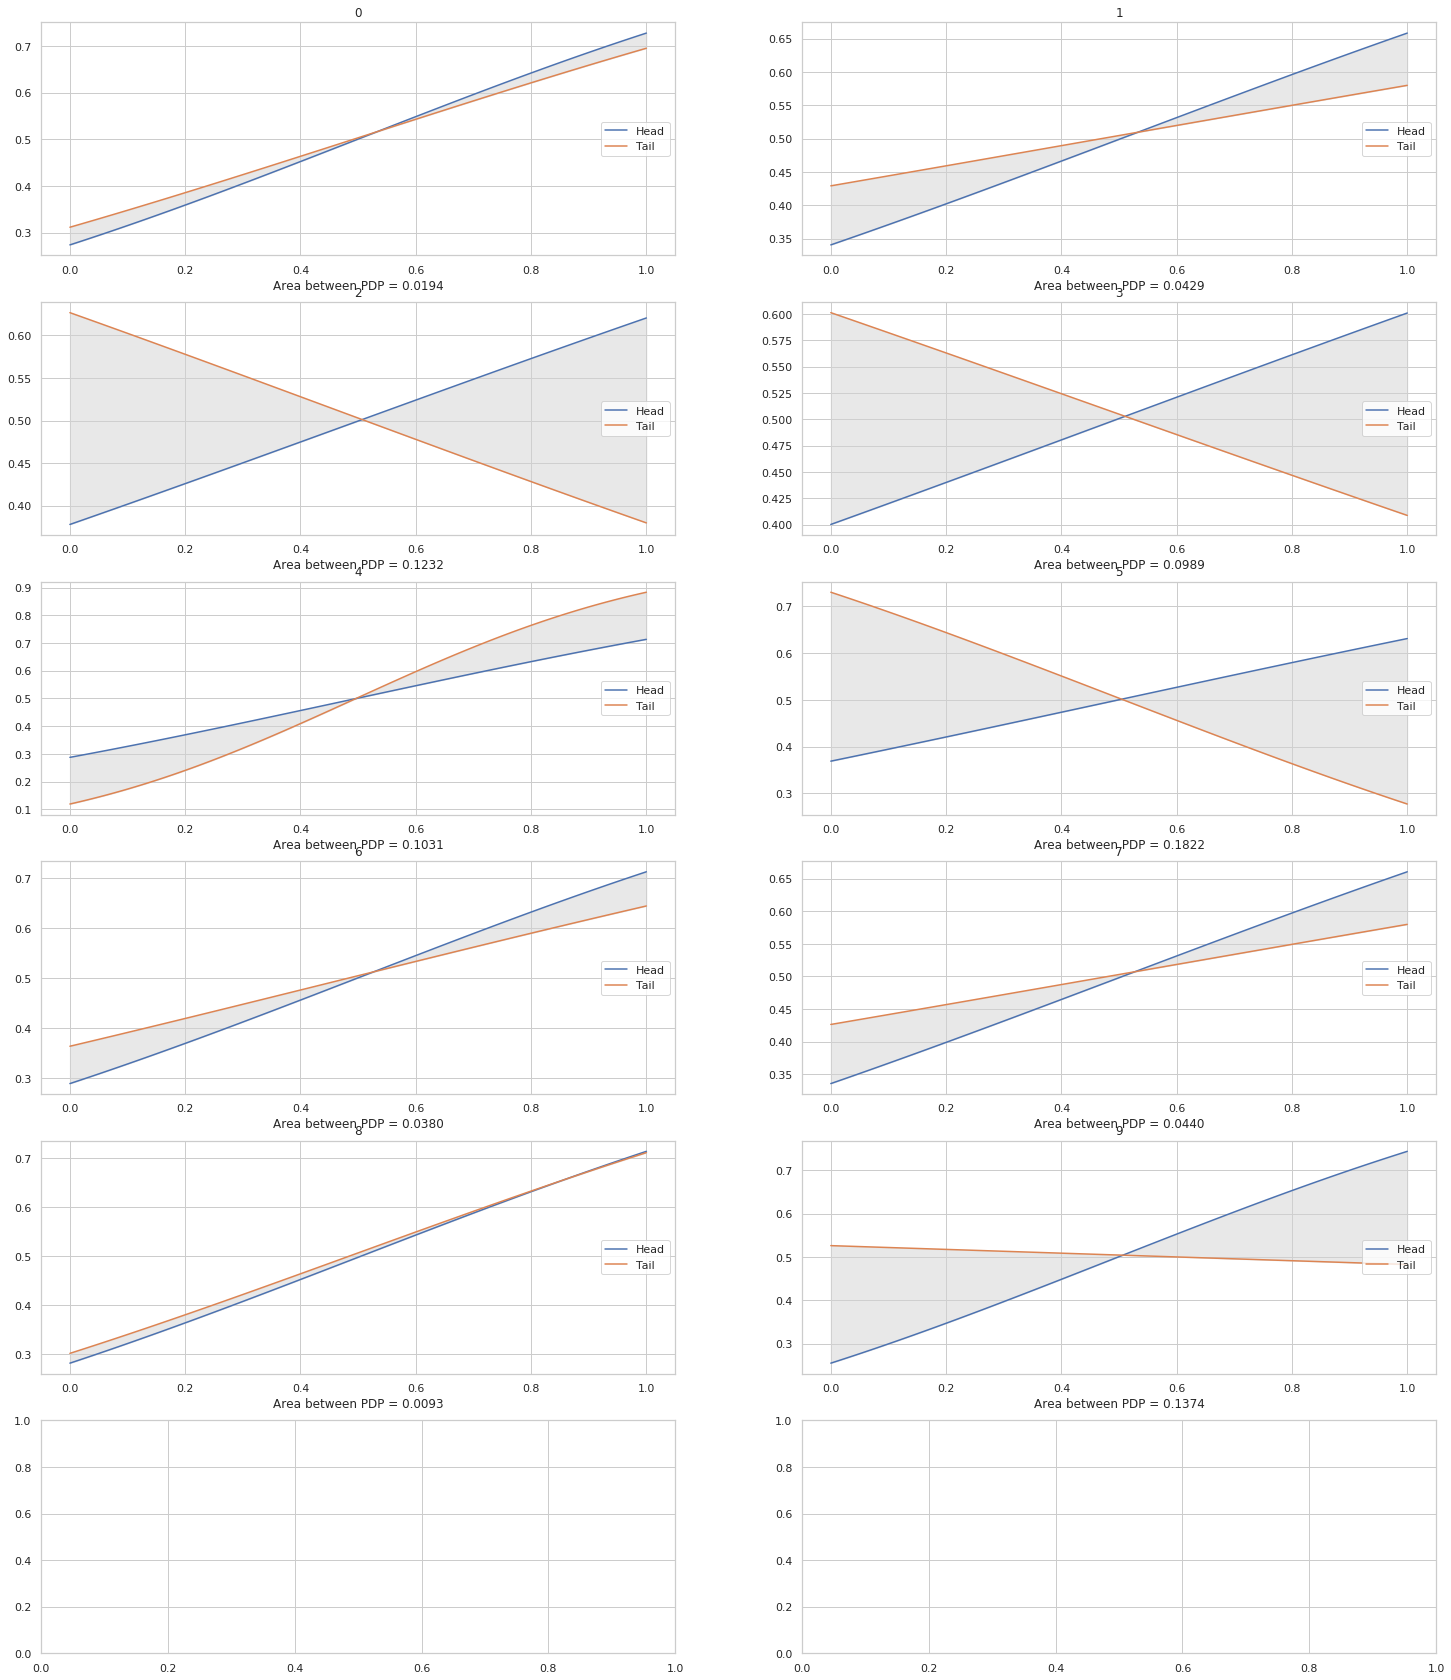

In [26]:
feat_no = x_data.columns.shape[0]
fig, ax = plt.subplots(ncols=2, nrows=(feat_no+1)//2, figsize=(25, 30))
for i, feature in enumerate(x_data.columns):
    compare_pdp(x_data, feature, model1=lr_head, model2=lr_tail, x_head=x_test_head, x_tail=x_test_tail, ax=ax[i//2][i%2])

Największą zmiane można zaobserwować przy zmiennych 2,3,5,9. Świadczy to o postępującym dryfie w danych.